In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa
import numpy as np
import os
# import os
import pandas as pd

In [41]:
x, sr = librosa.load("GEM.mp3",sr=8000)
print(x.shape, sr)

(1494631,) 8000


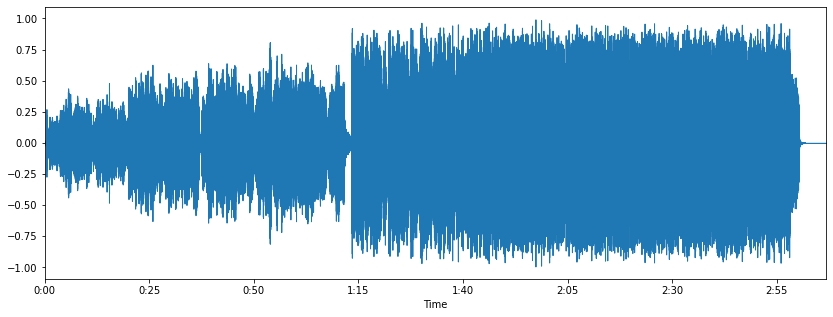

In [42]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

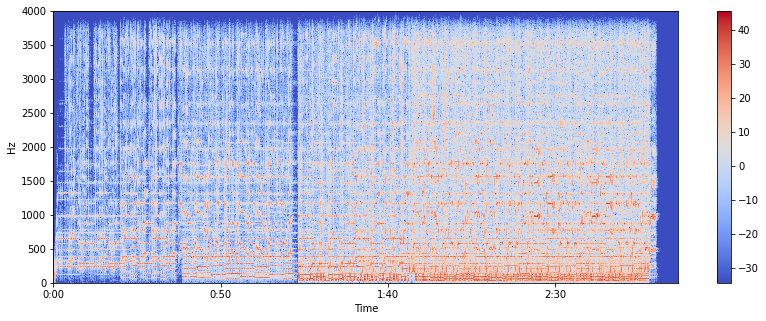

In [43]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize = (14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis = 'time', y_axis = 'hz')
plt.colorbar()

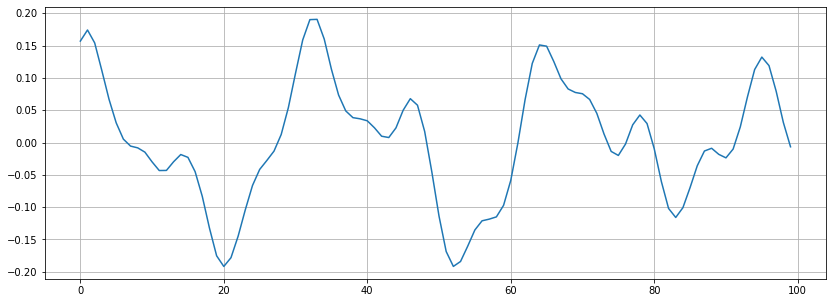

In [44]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [45]:
# zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
# print(sum(zero_crossings))

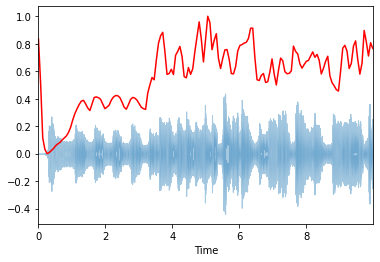

In [46]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x[:80000], sr=sr)[0]
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=8000)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x[:80000], sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

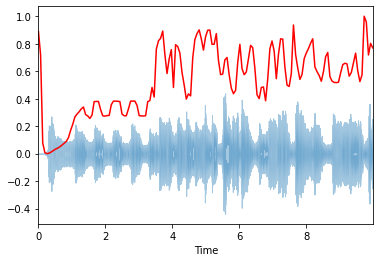

In [47]:
spectral_rolloff = librosa.feature.spectral_rolloff(x[:80000], sr=sr)[0]
librosa.display.waveplot(x[:80000], sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 2920)


<AxesSubplot:xlabel='Time'>

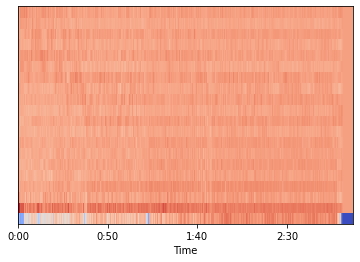

In [48]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [49]:
generals = 'JJ JL GEM adele ID sia Alien Crowd Cyndi'.split()
data_set = []
label_set = []
label2id = {general:i for i,general in enumerate(generals)}
id2label = {i:general for i,general in enumerate(generals)}

print(label2id)

for g in generals:
    print(g)
    for filename in os.listdir(f'./generals/{g}/'):
        songname = f'./generals/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True)
        
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        data_set.append([float(i) for i in to_append.split(" ")])
        label_set.append(label2id[g])

from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

scaler = StandardScaler()
np1 = np.array(data_set)
X = scaler.fit_transform(np.array(data_set, dtype = float))
y = np_utils.to_categorical(np.array(label_set))

print("X =" , X.shape, "Y = ", y.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


{'JJ': 0, 'JL': 1, 'GEM': 2, 'adele': 3, 'ID': 4, 'sia': 5, 'Alien': 6, 'Crowd': 7, 'Cyndi': 8}
JJ


C:\Users\wangyucheng\Anaconda3\lib\site-packages\librosa\util\utils.py:826: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return (x > x_pad[inds1]) & (x >= x_pad[inds2])
C:\Users\wangyucheng\Anaconda3\lib\site-packages\librosa\core\audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),


JL
GEM
adele
ID
sia
Alien
Crowd
Cyndi
X = (810, 26) Y =  (810, 9)


In [57]:
import copy
data_save = copy.deepcopy(data_set)
label_save = []
for i in label_set:
    label_save.append(id2label[i])

for i in range(len(data_save)):
    data_save[i].append(label_save[i])

In [58]:
mfcc_col = []
for i in range(20):
    mcff_label = 'mfcc'+ str(i+1)
    mfcc_col.append(mcff_label)

columns=['chroma_stft','rms','spec_cent','spec_bw','rolloff','zcr'] + mfcc_col + ['singer' ]
print(columns)

df1 = pd.DataFrame(data_save,
                   columns= columns)
df1.to_csv('singer_distinguish.csv')  

['chroma_stft', 'rms', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'singer']


In [59]:
from keras import models
from keras.layers import Dense, Dropout

def create_model():
    model = models.Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))
    return model

model = create_model()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

trainhistory = model.fit(X_train, y_train, epochs=50, batch_size=128,verbose=2,validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test,y_test)

print('test_acc: ',test_acc)


Train on 453 samples, validate on 114 samples
Epoch 1/50
 - 1s - loss: 2.2332 - accuracy: 0.1082 - val_loss: 2.1438 - val_accuracy: 0.1579
Epoch 2/50
 - 0s - loss: 2.1004 - accuracy: 0.2075 - val_loss: 2.0559 - val_accuracy: 0.3333
Epoch 3/50
 - 0s - loss: 1.9789 - accuracy: 0.3576 - val_loss: 1.9597 - val_accuracy: 0.3947
Epoch 4/50
 - 0s - loss: 1.8950 - accuracy: 0.3841 - val_loss: 1.8579 - val_accuracy: 0.4386
Epoch 5/50
 - 0s - loss: 1.7555 - accuracy: 0.4437 - val_loss: 1.7520 - val_accuracy: 0.5000
Epoch 6/50
 - 0s - loss: 1.6507 - accuracy: 0.4857 - val_loss: 1.6518 - val_accuracy: 0.4912
Epoch 7/50
 - 0s - loss: 1.5376 - accuracy: 0.5386 - val_loss: 1.5480 - val_accuracy: 0.5351
Epoch 8/50
 - 0s - loss: 1.4489 - accuracy: 0.5541 - val_loss: 1.4378 - val_accuracy: 0.5702
Epoch 9/50
 - 0s - loss: 1.3578 - accuracy: 0.5563 - val_loss: 1.3458 - val_accuracy: 0.5877
Epoch 10/50
 - 0s - loss: 1.2269 - accuracy: 0.6203 - val_loss: 1.2772 - val_accuracy: 0.6228
Epoch 11/50
 - 0s - los

In [60]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

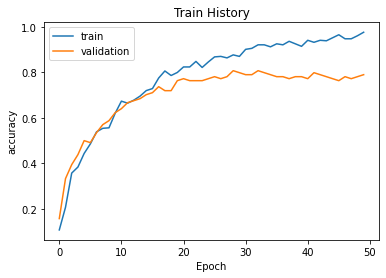

In [61]:
show_train_history(trainhistory,'accuracy','val_accuracy')

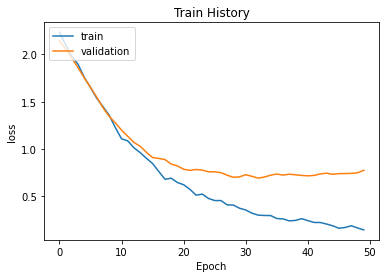

In [62]:
show_train_history(trainhistory,'loss','val_loss')